In [12]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix

In [2]:
import requests

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names = np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

print('column names: ', names)

column names:  ['GRB_name' 'GRB_name_Fermi' 'T0' 'ra' 'decl' 'pos_error' 'T90'
 'T90_error' 'T90_start' 'fluence' 'fluence_error' 'redshift' "'T100'"
 'GBM_located' 'mjd_(T0)']


In [3]:
z=np.array([float(i) for i in data[np.where(names=='redshift')[0][0]]])
t=np.array([float(i) for i in data[np.where(names=='T90')[0][0]]])
f=np.array([float(i) for i in data[np.where(names=='fluence')[0][0]]])

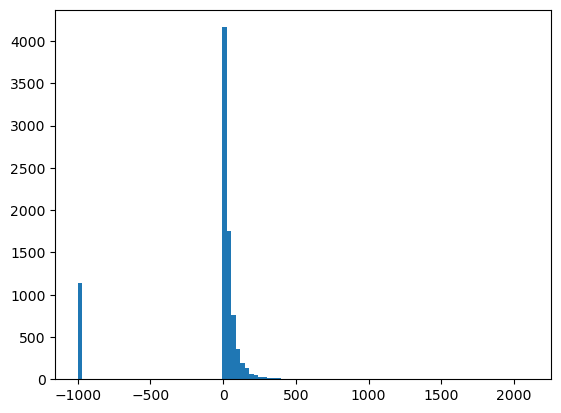

In [4]:
#histogram for the time values
plt.hist(t,bins=100)
plt.show()

In [5]:
#some values can be nan or -999 => clean
t_clean = t[~np.isnan(t)]
t_clean = t_clean[t_clean!=-999]
z_clean = z[~np.isnan(z)]
z_clean = z_clean[z_clean!=-999]
f_clean = f[~np.isnan(f)]
f_clean = f_clean[f_clean!=-999]

print('clean array t: ',t_clean[0:10])
print('min time: ', t_clean.min(), 'max time: ', t_clean.max())
print('\n')
print('clean array z: ',z_clean[0:10])
print('min time: ', z_clean.min(), 'max time: ', z_clean.max())
print('\n')
print('clean array z: ',f_clean[0:5])
print('min time: ', f_clean.min(), 'max time: ', f_clean.max())

clean array t:  [ 42.753   0.704   5.888  32.768  14.592   3.072  12.544  49.665 102.658
  17.152]
min time:  0.008 max time:  2100.0


clean array z:  [0.767 0.31  0.963 1.36  2.627 1.847 2.823 0.42  1.898 3.315]
min time:  0.0085 max time:  11.0


clean array z:  [6.1406e-06 1.1518e-07 9.5054e-07 3.2700e-06 2.0176e-06]
min time:  0.0 max time:  0.038836


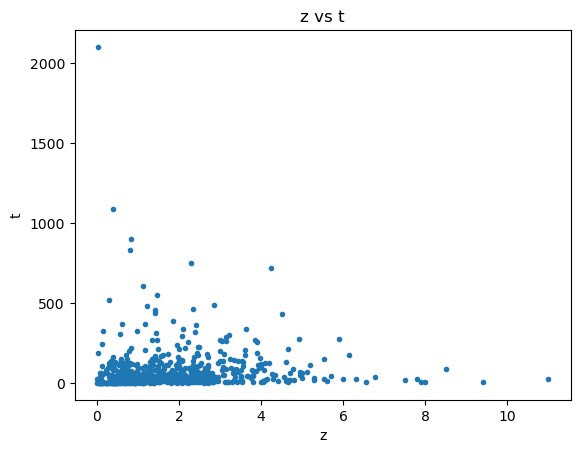

In [6]:
t_z=[]
z_t=[]
for i in range(len(t)):
    if(t[i]!=-999)and(z[i]!=-999):
        t_z.append(t[i])
        z_t.append(z[i])

plt.plot(z_t, t_z, '.')
plt.title('z vs t')
plt.xlabel('z')
plt.ylabel('t')
plt.show()

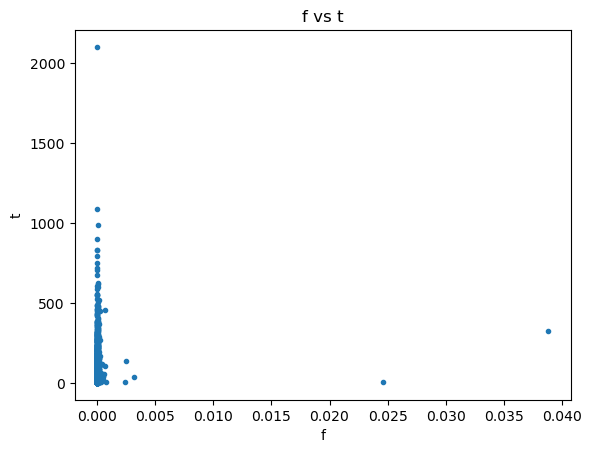

In [7]:
t_f=[]
f_t=[]
for i in range(len(t)):
    if(t[i]!=-999)and(f[i]!=-999):
        t_f.append(t[i])
        f_t.append(f[i])

plt.plot(f_t, t_f, '.')
plt.title('f vs t')
plt.xlabel('f')
plt.ylabel('t')
plt.show()

/tmp/ipykernel_582/2664119889.py:2: RuntimeWarning: divide by zero encountered in log10
  f_log=np.log10(f_clean)
/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py:6779: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)


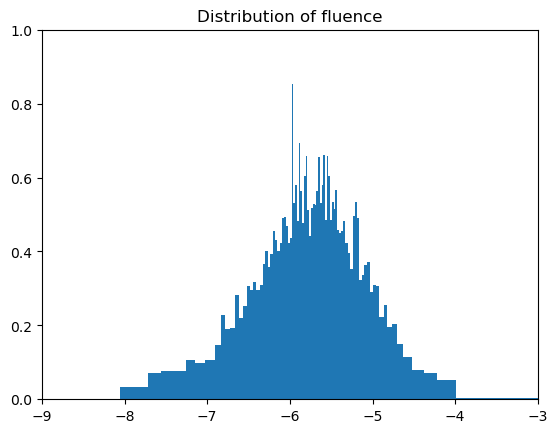

In [8]:
#re-binning with variable number of bins
f_log=np.log10(f_clean)
N_bins_f=90
bins_set_f=np.append(np.sort(f_log)[::N_bins_f], np.max(f_log))

data_f=plt.hist(f_log, bins=bins_set_f, density=True)
plt.title('Distribution of fluence')
plt.xlim(-9,-3)
plt.ylim(0,1)
plt.show()

In [9]:
#not so informative

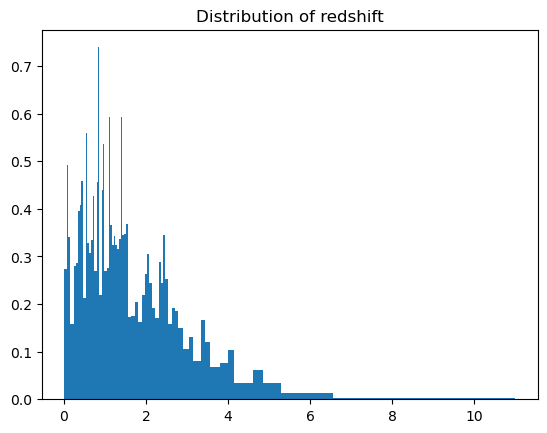

In [10]:
#re-binning with variable number of bins
N_bins_z=10
bins_set_z=np.append(np.sort(z_clean)[::N_bins_z], np.max(z_clean))

data_z=plt.hist(z_clean, bins=bins_set_z, density=True)
plt.title('Distribution of redshift')
plt.show()

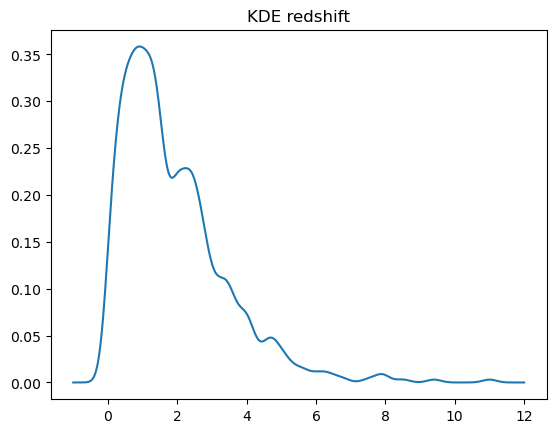

In [14]:
#KDE on redshift
z_kde=z_clean[:,np.newaxis] #reshape of data
kde_z = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(z_kde) #fit the model to the data
xgrid_z=(np.linspace(-1,12,1000))
ygrid_z = np.exp(kde_z.score_samples((xgrid_z)[:,np.newaxis])) #score in log => exp

plt.plot(xgrid_z,ygrid_z)
plt.title('KDE redshift')
plt.show()

In [16]:
#Clusters with KMeans
clf_z = KMeans(n_clusters=2, n_init='auto') #2 clusters
clf_z.fit(z_kde)

KMeans(n_clusters=2)

In [17]:
#find location and predictions
centers_z = clf_z.cluster_centers_ #location of the clusters
centers_z = np.squeeze(centers_z)
if centers_z[1]<centers_z[0]:
  centers_z=centers_z[::-1]
print('Clusters centers: ', centers_z)
labels_predict_z = clf_z.predict(z_kde) #prediction on the clusters of kde
edge_z = (np.mean([max(z_kde[labels_predict_z==1]), min(z_kde[labels_predict_z==0])])) #edge between 2 clusters
print('Edge: ', edge_z)

Clusters centers:  [1.18550041 3.91348623]
Edge:  2.5595


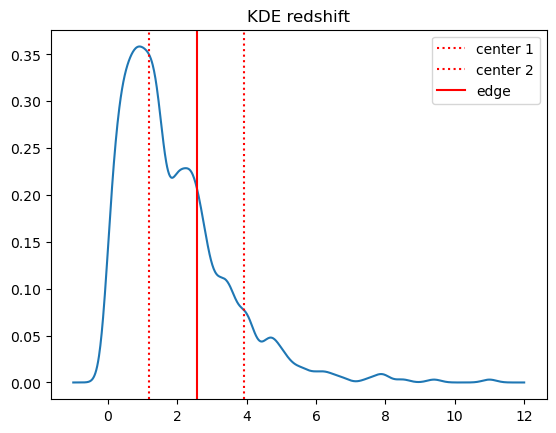

In [18]:
#KDE with positions of clusters
plt.plot(xgrid_z,ygrid_z)
plt.axvline(centers_z[0], c='red',ls='dotted', label='center 1')
plt.axvline(centers_z[1], c='red',ls='dotted', label='center 2')
plt.axvline(edge_z,c='red', label='edge')
plt.legend()
plt.title('KDE redshift')
plt.show()

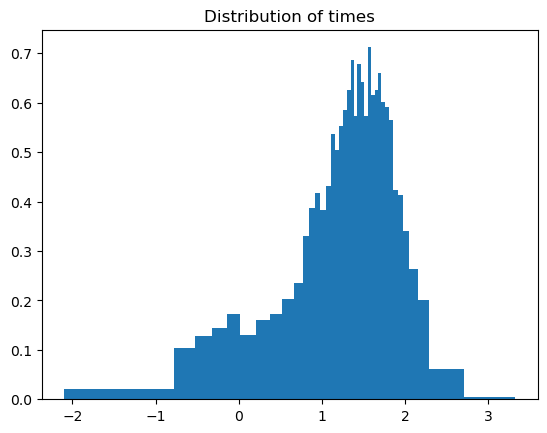

In [19]:
#re-binning with variable number of bins
t_log=np.log10(t_clean)
N_bins_t=200
bins_set=np.append(np.sort(t_log)[::N_bins_t], np.max(t_log))

data_t=plt.hist(t_log, bins=bins_set, density=True)
plt.title('Distribution of times')
plt.show()

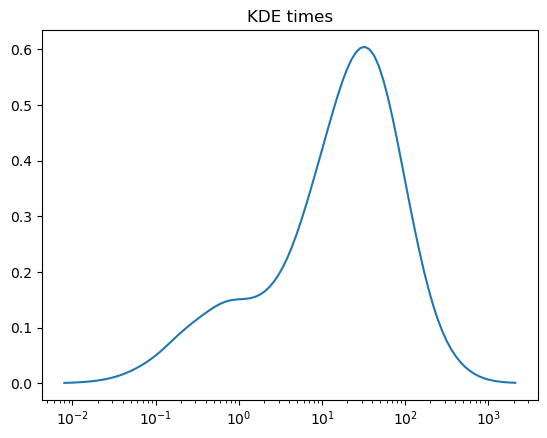

In [21]:
#KDE of time
logt=t_log[:,np.newaxis] #reshape of the data
kde_t = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(logt) #fit the model to the data
xgrid_t=np.logspace(logt.min(),logt.max(),100)
ygrid_t = np.exp(kde_t.score_samples(np.log10(xgrid_t)[:,np.newaxis]))

plt.plot(xgrid_t,ygrid_t)
plt.title('KDE times')
plt.semilogx()
plt.show()

In [22]:
#clusters with kmeans
clf_t = KMeans(n_clusters=2,n_init='auto') #2 clusters
clf_t.fit(logt.reshape(-1,1))

#find location and predictions
centers_t = clf_t.cluster_centers_ #location of the clusters
centers_t = 10**np.squeeze(centers_t)
print('Clusters centers: ', centers_t)

labels_predict_kde = clf_t.predict(logt) #prediction on the clusters of kde

if centers_t[1]<centers_t[0]:
  centers_t=centers_t[::-1]
  labels_predict_kde = np.array(~np.array(labels_predict_kde,dtype='bool'),dtype='int') # Swap 0 <--> 1
  print('Clusters centers swap: ', centers_t)

edge_t = 10**( np.mean( [max(logt[labels_predict_kde==0]), min(logt[labels_predict_kde==1]) ]))
print('Edge: ', edge_t)

Clusters centers:  [32.64924588  0.87597161]
Clusters centers swap:  [ 0.87597161 32.64924588]
Edge:  5.330966141329355


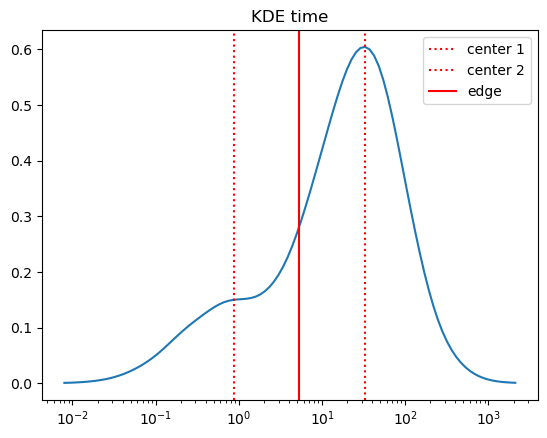

In [23]:
#KDE with positions of clusters
plt.plot(xgrid_t,ygrid_t)
plt.axvline(centers_t[0], c='red',ls='dotted', label='center 1')
plt.axvline(centers_t[1], c='red',ls='dotted', label='center 2')
plt.axvline(edge_t,c='red', label='edge')
plt.legend()
plt.semilogx()
plt.title('KDE time')
plt.show()

In [24]:
#cluster with gaussian mixture
gauss_t = GaussianMixture(2).fit(logt)
means_t = 10**np.squeeze(gauss_t.means_)
labels_predict_t = gauss_t.predict_proba(logt)
if means_t[0]>means_t[1]:
    means_t=means_t[::-1]
    labels_predict_t= labels_predict_t[:,::-1]
ygauss_t = np.exp(gauss_t.score_samples( np.log10(xgrid_t)[:,np.newaxis] ))

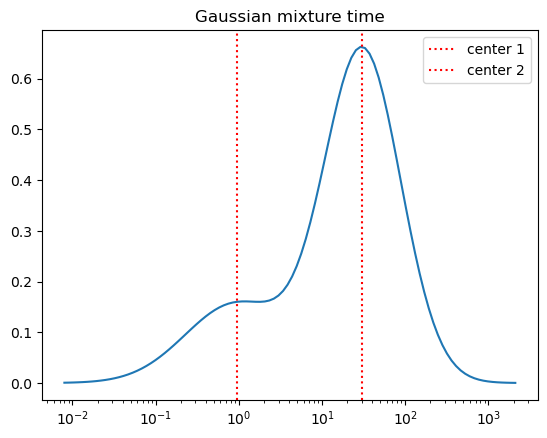

In [25]:
#gaussian mixture with positions of clusters
plt.plot(xgrid_t, ygauss_t)
plt.axvline(means_t[0], c='red',ls='dotted', label='center 1')
plt.axvline(means_t[1], c='red',ls='dotted', label='center 2')
plt.legend()
plt.semilogx()
plt.title('Gaussian mixture time')
plt.show()

In [26]:
print('predicted label form gauss: \n', labels_predict_t)
#labels need to be reshaped
labels_predict_gauss= np.array(labels_predict_t[:,0]<labels_predict_t[:,1],dtype='int')
print('\n reshaped label form gauss: \n', labels_predict_gauss)

predicted label form gauss: 
 [[6.71458632e-03 9.93285414e-01]
 [9.92172350e-01 7.82765007e-03]
 [2.55932330e-01 7.44067670e-01]
 ...
 [6.22969443e-01 3.77030557e-01]
 [8.78687999e-04 9.99121312e-01]
 [3.18111988e-01 6.81888012e-01]]

 reshaped label form gauss: 
 [1 0 1 ... 0 1 1]


In [27]:
#confusion matrix for the 2 methods
print('confusion matrix for the 2 methods: \n', confusion_matrix(labels_predict_gauss,labels_predict_kde))

confusion matrix for the 2 methods: 
 [[1672    0]
 [ 256 5696]]
